In [ ]:
##将样本名替换为ID
import pandas as pd

# 读取colodata_allTPM.txt (有列名，没有行名)
colodata = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/ssGSEA/colodata_allTPM.txt', sep='\t', header=0)
print(colodata.shape)
# 创建样本名到ID的映射，colodata的第1列为样本名，第2列为ID
sample_to_id = dict(zip(colodata.iloc[:, 0], colodata.iloc[:, 1]))

# 读取callTPM_G.txt (有列名和行名)
callTPM = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/callTPM_G.txt', sep='\t', header=0, index_col=0)
print(callTPM.shape)
# 获取callTPM_G.txt的列名（从第2列开始的样本名）
sample_names = callTPM.columns

# 将样本名替换为ID
new_columns = [sample_to_id.get(name, name) for name in sample_names]
callTPM.columns = new_columns

# 保存修改后的文件
callTPM.to_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/callTPM_G_ID.txt', sep='\t')
print(callTPM.shape)

In [ ]:
import pandas as pd
import numpy as np
import csv
# 读取基因表达数据
expression_data = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/all_G.txt', sep=' ', index_col=0)

# 读取质心数据
centroids = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/ClaNC840_centroids.txt', sep='\t', index_col=0)

#确保基因表达数据和质心数据对齐
common_genes = expression_data.index.intersection(centroids.index)

# 筛选出交集基因的数据
expression_data = expression_data.loc[common_genes]
centroids = centroids.loc[common_genes]

#标准化基因表达数据
#expression_data = np.log2(expression_data + 1)
# 对每一行（即每个基因）进行标准化
expression_data = (expression_data - expression_data.mean(axis=1).values[:, None]) / expression_data.std(axis=1).values[:, None]

#计算欧氏距离
def calculate_euclidean_distance(sample, centroid):
    return np.sqrt(np.sum((sample - centroid) ** 2))

# 存储每个样本与四个亚型质心的距离
distances = []

# 遍历每个样本
for sample_name, sample in expression_data.iteritems():
    # 计算该样本与每个亚型质心的距离
    distance_to_centroids = {}
    for centroid_name, centroid in centroids.iteritems():
        distance_to_centroids[centroid_name] = calculate_euclidean_distance(sample, centroid)
    
    # 找到最小距离对应的亚型
    closest_centroid = min(distance_to_centroids, key=distance_to_centroids.get)
    
    # 存储结果
    distances.append((sample_name, closest_centroid))

# 将结果转换为DataFrame
result = pd.DataFrame(distances, columns=['Sample', 'Assigned_Subtype'])

# 保存分型结果
result.to_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_assigned_subtypes.csv', index=False, quoting=csv.QUOTE_ALL)

print("分型结果已保存。")


(736,)


/tmp/ipykernel_54505/1174061353.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sample_name, sample in expression_data.iteritems():
/tmp/ipykernel_54505/1174061353.py:33: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for centroid_name, centroid in centroids.iteritems():


分型结果已保存。


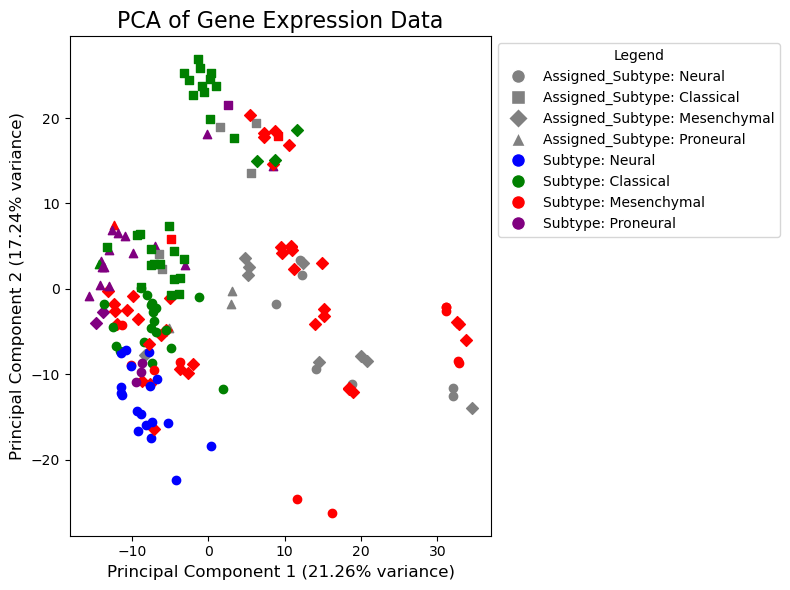

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.lines as mlines

# 读取基因表达数据
expression_data = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/all_G.txt', sep=' ', index_col=0)

# 读取质心数据
centroids = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/ClaNC840_centroids.txt', sep='\t', index_col=0)

# 确保基因表达数据和质心数据对齐
common_genes = expression_data.index.intersection(centroids.index)

# 筛选出交集基因的数据
expression_data = expression_data.loc[common_genes]
centroids = centroids.loc[common_genes]

# 标准化基因表达数据
expression_data = np.log2(expression_data + 1)  # 对数据进行log2转换
# 对每一行（即每个基因）进行标准化
expression_data = (expression_data - expression_data.mean(axis=1).values[:, None]) / expression_data.std(axis=1).values[:, None]

# 使用 PCA 降维到 2 维
pca = PCA(n_components=2)  # 降维到二维
pca_result = pca.fit_transform(expression_data.T)  # 转置后进行PCA，行是样本，列是基因

# 获取 PCA 各主成分的方差解释比例
explained_variance = pca.explained_variance_ratio_

# 读取tcga_result_centroid.txt，获取样本和对应的分型信息
tcga_result = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_result_centroid.txt', sep='\t')

# 创建样本到 Assigned_Subtype 和 subtype 的映射
sample_info = {row['sample']: (row['Assigned_Subtype'], row['subtype']) for _, row in tcga_result.iterrows()}

# 定义形状和颜色映射
shapes = {'Neural': 'o', 'Classical': 's', 'Mesenchymal': 'D', 'Proneural': '^'}  # 假设四种亚型
colors = {'Neural': 'blue', 'Classical': 'green', 'Mesenchymal': 'red', 'Proneural': 'purple'}  # 假设四种亚型
default_color = 'gray'  # 默认颜色

# 绘制 PCA 图
plt.figure(figsize=(8, 6))

# 为每个样本指定颜色和形状
for sample_name, pca_coords in zip(expression_data.columns, pca_result):
    assigned_subtype, subtype = sample_info.get(sample_name, (None, None))
    
    # 处理subtype列的空值和异常值
    if subtype not in colors:
        color = default_color  # 设置默认颜色（如灰色）
    else:
        color = colors[subtype]  # 根据subtype映射颜色
    
    # 处理Assigned_Subtype列的形状
    if assigned_subtype not in shapes:
        shape = 'o'  # 默认形状
    else:
        shape = shapes[assigned_subtype]  # 根据Assigned_Subtype映射形状

    # 绘制样本点
    plt.scatter(pca_coords[0], pca_coords[1], c=color, marker=shape)

# 添加图例
shape_labels = [mlines.Line2D([], [], marker=shapes[stype], color='w', markerfacecolor='gray', markersize=10, label=f'Assigned_Subtype: {stype}') for stype in shapes]
color_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor=colors.get(stype, default_color), markersize=10, label=f'Subtype: {stype}') for stype in colors]

# 将颜色和形状的图例合并，并设置图例字体大小，图例位置在图片外
plt.legend(handles=shape_labels + color_labels, title='Legend', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# 添加标题和标签
plt.title('PCA of Gene Expression Data', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=12)  # 显示PC1的方差比例
plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=12)  # 显示PC2的方差比例

# 显示图形
plt.tight_layout()  # 调整布局，避免图例被截断
plt.show()


In [79]:
import pandas as pd

# 读取两个文件
assigned_subtypes = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_assigned_subtypes.csv', sep=',')
colodata_allTPM = pd.read_csv('/cluster/home/tmp/GBM/RNA/merge/allmeta.txt', sep='\t')

# 确保两个文件的第一列为样本名称
assigned_subtypes.columns = ['sample', 'Assigned_Subtype']  # 假设列名为 Sample 和 Assigned_Subtype
#colodata_allTPM.columns = ['Sample'] + list(colodata_allTPM.columns[1:])  # 其他列保持不变

# 合并两个文件，基于 "Sample" 列
merged_data = pd.merge(assigned_subtypes, colodata_allTPM, on='sample', how='inner')

# 保存合并结果
merged_data.to_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_result_centroid.txt', sep='\t', index=False)

print("文件合并完成，并已保存。")


文件合并完成，并已保存。


In [80]:
import pandas as pd

# 读取数据
df = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_result_centroid.txt', sep='\t')

# 过滤 'subtype' 列为 'Neural', 'Classical', 'Mesenchymal', 'Proneural' 的行
filtered_df = df[df['subtype'].isin(['Neural', 'Classical', 'Mesenchymal', 'Proneural'])]

# 统计与 'Assigned_Subtype' 列相同的 'subtype' 列的行数
count_matching = (filtered_df['subtype'] == filtered_df['Assigned_Subtype']).sum()

print(f"匹配的行数：{count_matching}")
row_count = filtered_df.shape[0]

print(f"过滤后的数据行数：{row_count}")


匹配的行数：99
过滤后的数据行数：142


In [82]:
import pandas as pd

# 读取数据
df = pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/centroid/tcga_result_centroid.txt', sep='\t')

# 过滤 Sample 列以 'P' 开头的行
p_df = df[df['sample'].str.startswith('G')]

# 统计 'subtype' 列与 'Assigned_Subtype' 列相同的行数
matching_rows = (p_df['subtype'] == p_df['Assigned_Subtype']).sum()

# 打印以 'P' 开头的行数
print(f"以 'P' 开头的行数: {len(p_df)}")

# 打印 'subtype' 与 'Assigned_Subtype' 相同的行数
print(f"匹配的行数: {matching_rows}")


以 'P' 开头的行数: 28
匹配的行数: 20
